# 6. Custom Plugin

## Overview

In this tutorial, we will learn how to create our own Mitsuba plugin directly in Python.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Create a BSDF plugin in Python</li>
  <li>Register custom plugin to the system</li>
  <li>Render our custom BSDF</li>
</ul>
    
</div>


### Step 1 - setup

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('/home/speierers/projects/mitsuba2-symbolic/build/python')

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('llvm_ad_rgb')

### Step 2 - implement the custom plugin

In [3]:
from mitsuba.core.xml import load_dict
from mitsuba.core import Float, UInt32, Frame3f, Color3f
from mitsuba.render import BSDF, BSDFSample3f, BSDFFlags, fresnel, reflect, refract

class MyBSDF(BSDF):
    def __init__(self, props):
        BSDF.__init__(self, props)
        
        # Read 'eta' and 'tint' properties from `props`
        self.eta = 1.33
        if props.has_property('eta'):
            self.eta = props['eta']
            
        self.tint = props['tint']
        
        # Set the BSDF flags
        reflection_flags   = BSDFFlags.DeltaReflection   | BSDFFlags.FrontSide | BSDFFlags.BackSide
        transmission_flags = BSDFFlags.DeltaTransmission | BSDFFlags.FrontSide | BSDFFlags.BackSide        
        self.m_components  = [reflection_flags, transmission_flags]
        self.m_flags = reflection_flags | transmission_flags
        
    def sample(self, ctx, si, sample1, sample2, active):
        # Compute Fresnel terms
        cos_theta_i = Frame3f.cos_theta(si.wi)        
        r_i, cos_theta_t, eta_it, eta_ti = fresnel(cos_theta_i, self.eta)
        t_i = 1.0 - r_i
         
        # Pick between reflection and transmission
        selected_r = (sample1 <= r_i) & active
        selected_t = ~selected_r & active
        
        # Fill up the BSDFSample struct
        bs = BSDFSample3f()
        bs.pdf = ek.select(selected_r, r_i, t_i)
        bs.sampled_component = ek.select(selected_r, UInt32(0), UInt32(1))
        bs.sampled_type      = ek.select(selected_r, UInt32(+BSDFFlags.DeltaReflection),
                                                     UInt32(+BSDFFlags.DeltaTransmission))
        bs.wo = ek.select(selected_r,
                          reflect(si.wi),
                          refract(si.wi, cos_theta_t, eta_ti))
        bs.eta = ek.select(selected_r, 1.0, eta_it)
        
        # Compute BSDF value (tinted reflections)
        value = Color3f(1.0)
        
        # For reflection, tint based on the incident angle (more tint at grazing angle)
        value[selected_r] = ek.lerp(Color3f(self.tint), Color3f(1.0), cos_theta_i)    
        
        # For transmission, radiance must be scaled to account for the solid angle compression
        value[selected_t] = value * ek.sqr(eta_ti)

        return ( bs, value )

    def eval(self, ctx, si, wo, active):
        return 0.0

    def pdf(self, ctx, si, wo, active):
        return 0.0

    def to_string(self):
        s = f'MyBSDF[\n'                   \
          + f'    eta={self.eta},\n'       \
          + f'    tint={self.tint},\n'     \
          + f']'
        return s

### Step 3 - register and instanciate the BSDF

In [4]:
from mitsuba.render import register_bsdf
register_bsdf("mybsdf", lambda props: MyBSDF(props))

In [5]:
from mitsuba.core.xml import load_dict
my_bsdf = load_dict({
    'type' : 'mybsdf',
    'tint' : [0.2, 0.9, 0.2],
    'eta' : 1.33
})

print(my_bsdf)

MyBSDF[
    eta=1.3300000429153442,
    tint=[0.20000000298023224, 0.8999999761581421, 0.20000000298023224],
]


### Step 4 - render

2021-04-22 16:14:16 INFO main [Scene] Embree ready. (took 15ms)

2021-04-22 16:14:16 INFO main [SamplingIntegrator] Start rendering...

2021-04-22 16:14:16 INFO main [SamplingIntegrator] Computation graph recorded. (took 9ms)

2021-04-22 16:14:16 INFO main [SamplingIntegrator] Code generation finished. (took 2ms)

2021-04-22 16:14:16 INFO main [SamplingIntegrator] Rendering finished. (took 107ms)

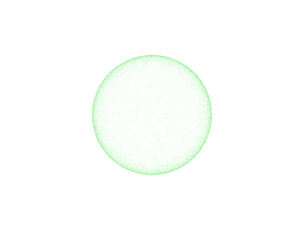

In [6]:
from matplotlib import pyplot as plt
from mitsuba.core import ScalarTransform4f
from mitsuba.python.util import render

scene = load_dict({
    'type' : 'scene',
    'integrator' : { 
        'type' : 'path' 
    },
    'light' : { 
        'type' : 'constant' 
    },
    'sphere' : {
        'type' : 'sphere',
        'bsdf' : my_bsdf
    },
    'sensor' : {
        'type' : 'perspective',
        'to_world' : ScalarTransform4f.look_at(origin=[0, -5, 5], 
                                               target=[0, 0, 0], 
                                               up=[0, 0, 1]),
    }
})

plt.imshow(render(scene)); plt.axis('off');

### *Reference API*

- [<code>mitsuba.core.xml.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)